## Exercise 2: Rigid and perspective transformations in homogeneous coordinates


In [23]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import RegularGridInterpolator

In these exercises we will assume a modern camera with completely square pixels. What are the skew parameters then?

- The skew parameters α and β, where α = 1 and β=0. 

### Mathematical exercises: Pinhole camera

- **Exercise 2.1**. Reuse the `box3` function from last week. Assume that f = 600, α = 1, β = 0, and δx = δy = 400. Given a traditional camera, what is the resolution in pixels?

For this camera the sensor has 2 × 400 = 800 pixels along each dimension i.e. a resolution of **800 × 800 pixels.**

$$ K = \begin{bmatrix} f & \beta f & \delta_x \\ 0 & \alpha f & \delta_y \\ 0 & 0 & 1 \end{bmatrix}$$


$$ K = \begin{bmatrix} 600 & 0 & 400 \\ 0 & 600 & 400 \\ 0 & 0 & 1 \end{bmatrix}$$

Also assume $R = I$, and $t = [0,.2,1.5]^T.$ Use `projectpoint` from last week, to project the points.

In [24]:
def box3d(n):
    comb=[(0.5,0.5),(0.5,-0.5),(-0.5,0.5),(-0.5,-0.5)]
    a=np.linspace(-0.5, 0.5, n)
    box=[0,0,0]

    for j in comb:
        for i in a:
            p=[i,j[0],j[1]]
            box=np.vstack([box, p])

    for j in comb:
        for i in a[1:-1]:
            p=[j[0],i,j[1]]
            box=np.vstack([box, p])

    for j in comb:
        for i in a[1:-1]:
            p=[j[0],j[1],i]
            box=np.vstack([box, p])

    for i in a:
        cross1=[i,0,0]   
        box=np.vstack([box, cross1])
    for i in a:
        cross2=[0,i,0]   
        box=np.vstack([box, cross2])
    for i in a:
        cross3=[0,0,i]   
        box=np.vstack([box, cross3])
      
    box=box[1:]

    return box


def projectpoints(K,Cam,Q):
    #projection matrix P
    P=K@Cam
    
    [m,n]=np.shape(Q)
    cnt=np.ones(m)
    Q_ext=np.column_stack((Q,cnt))
    
    Q_ext=np.transpose(Q_ext)
    
    projection=P@(Q_ext)
    
    qx=np.transpose([projection[0]/projection[2]])
    qy=np.transpose([projection[1]/projection[2]])
    
    project2D=np.column_stack((qx,qy))
    
    project3D=np.transpose(projection)
    
    return P, project2D, project3D

In [25]:
K=np.array([[600,0,400],[0,600,400],[0,0,1]]) #camera matrix
R=np.array([[1,0,0],[0,1,0],[0,0,1]]) #rotation
t=np.transpose([0,0.2,1.5]) #translation
Q=box3d(16) #n points in 3D to be projected into the camera

Cam=np.column_stack((R,t))

P,points2D,points3D=projectpoints(K,Cam,Q)
print('The projection matrix of the camera is:')
print(P)

The projection matrix of the camera is:
[[600.    0.  400.  600. ]
 [  0.  600.  400.  720. ]
 [  0.    0.    1.    1.5]]


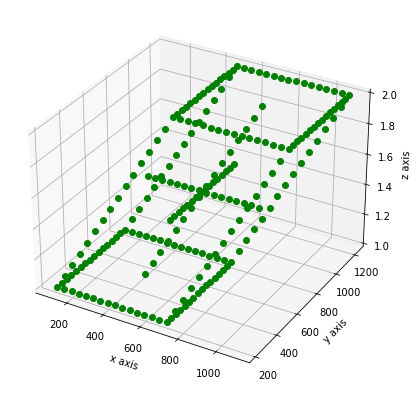

In [26]:
# Create a figure, and specify the size  
fig = plt.figure(figsize=(15,15))
# Create axes 
ax = fig.add_subplot(121, projection='3d')

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

for point in points3D:
    ax.plot(point[0], point[1], point[2], 'go')

Are all the points are captured by the image sensor? 


In [27]:
list_coord=[]
for coord in points2D: 
    if (coord[0]> 800) or (coord[1] > 800):
        list_coord.append(list(coord))

print('The points not caputed by the image sensor are:',list_coord)

The points not caputed by the image sensor are: [[100.0, 820.0], [140.0, 820.0], [180.0, 820.0], [220.0, 820.0], [260.0, 820.0], [300.0, 820.0], [340.0, 820.0], [380.0, 820.0], [420.0, 820.0], [460.0, 820.0], [500.0, 820.0], [540.0, 820.0], [580.0, 820.0], [620.0, 820.0], [660.0, 820.0], [700.0, 820.0]]


<font color='darkblue'> Some points have an y value greater than 800, and are not visible in the image, as they are outside the image sensor.
 

Where does the corner **$P_1 = [−0.5, −0.5, −0.5]$** project to?

In [28]:
P1=[-0.5,-0.5,-0.5]

#Function created to find a specific 2D projected point. 
def find_projected2Dpoint(Q,points2D,P1):
    for ind,row in enumerate(Q):    
        if np.all(row==P1):
            coord=points2D[ind]
    return coord


coord= find_projected2Dpoint(Q,points2D,P1)

print('The corner P1 project to:',coord)

The corner P1 project to: [100. 220.]


- **Exercise 2.2**. Create a new or change your function `projectpoint` to a version that also takes `dist` as an input. The list dist should contain the distortion coefficients $[k3, k5, k7, . . . ].$ Make the function work for at least 3 coefficients.


In [29]:
def projectpoints_2D(K,Cam,Q,dist):
    
    [m,n]=np.shape(Q)
    cnt=np.ones(m)
    Q_ext=np.column_stack((Q,cnt))
    
    Q_ext=np.transpose(Q_ext)
   
    projection=Cam@(Q_ext)
    
    Pz=projection[2]
    qx=np.transpose([projection[0]/projection[2]])
    qy=np.transpose([projection[1]/projection[2]])
    points2D=np.column_stack((qx,qy))
    
    r=np.sqrt(points2D.T[0]**2+points2D.T[1]**2)
    
    Ar=dist[0]*(r**2)+dist[1]*(r**4)+dist[2]*(r**6)
    dist= points2D.T*(1+Ar)
 
    Px= dist[0]*Pz
    Py= dist[1]*Pz
    points3D=np.column_stack((Px,Py,Pz))
    
    P=K@points3D.T #homogeneous coordinates
    
    #inhomogeneous coordinates
    qx_f=np.transpose([P[0]/P[2]]) 
    qy_f=np.transpose([P[1]/P[2]])
    
    dist_points=np.column_stack((qx_f,qy_f))
    
    return dist_points,P.T

Where does the corner **P1** project to?

In [30]:
dist=[-0.2, 0 ,0]
dist_points,P_3D=projectpoints_2D(K,Cam,Q,dist)

coord= find_projected2Dpoint(Q,dist_points,P1)

print('The corner P1 project to:',coord)

The corner P1 project to: [120.4  232.24]


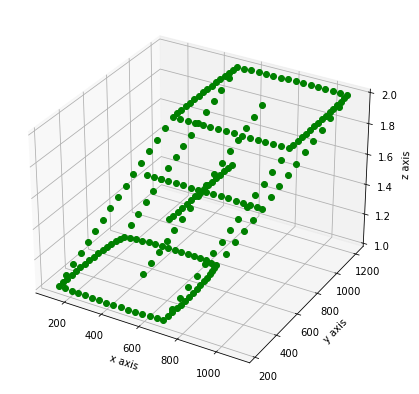

In [31]:
# Create a figure, and specify the size  
fig = plt.figure(figsize=(15,15))
# Create axes 
ax = fig.add_subplot(121, projection='3d')

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

for point in P_3D:
    ax.plot(point[0], point[1], point[2], 'go')

Are all the points captured by the image sensor?

In [32]:
list_coord=[]
for coord in dist_points:
    if (coord[0]> 800) or (coord[1] > 800):
        list_coord.append(list(coord))

print('The points not caputed by the image sensor are:',list_coord)

The points not caputed by the image sensor are: []


<font color='darkblue'> All the points are now projecting inside the image, and will thus be visible.
    
    

Plot the results and try changing the distortion coefficients. Do they behave as they should?

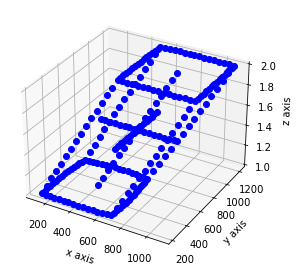

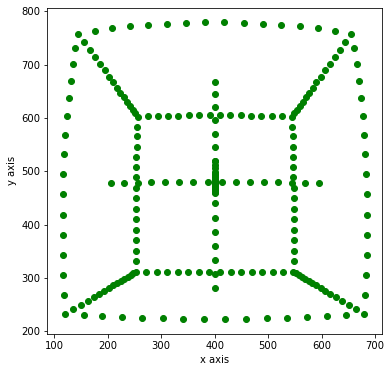

In [33]:
# Create a figure, and specify the size  
fig = plt.figure(figsize=(10,10))
# Create axes 
ax = fig.add_subplot(121, projection='3d')

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')

for point in P_3D:
    ax.plot(point[0], point[1], point[2], 'bo')

    
# Create a figure, and specify the size  
fig = plt.figure(figsize=(6,6))
# Create axes 
ax = fig.add_subplot()

ax.set_xlabel('x axis')
ax.set_ylabel('y axis')

for point in dist_points:
    ax.plot(point[0], point[1],'go')

plt.show()

Changing the distortion coefficients:


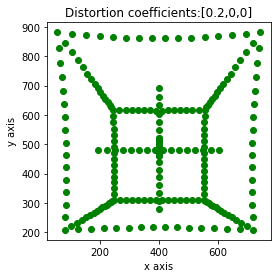

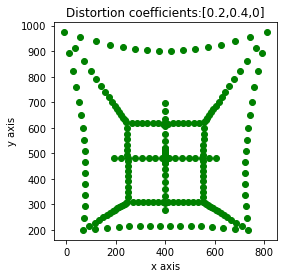

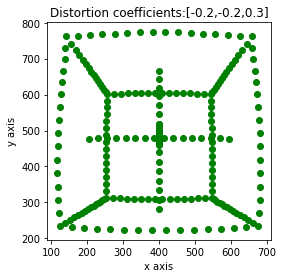

In [34]:
print('\033[1m'+'Changing the distortion coefficients:'+ '\033[0m')

dist=[[0.2, 0 ,0],[0.2, 0.4 ,0],[-0.2, -0.2 ,0.3]]
for i,a in enumerate(dist):

    fig = plt.figure(figsize=(4,4)) 
    ax = fig.add_subplot()
    
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')

    dist_points,P_3D=projectpoints_2D(K,Cam,Q,a)
    for point in dist_points:
        ax.plot(point[0], point[1],'go')
        
    plt.title('Distortion coefficients:[{},{},{}]'.format(a[0],a[1],a[2]))


- **Exercise 2.3**. Using the captured picture using a GoPro. Assume that the focal length is $f$=0.455732 multiplied by the image width, and a reasonable guess of principal point. The distortion coefficients are: 

    $k_3$=−0.245031, $k_5$ = 0.071524, $k_7$ = −0.00994978

    **What is K?**

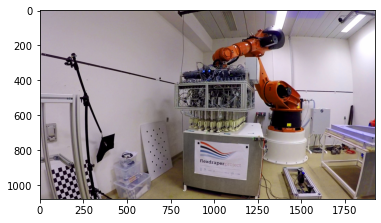

In [35]:
GoPro = cv2.imread("gopro_robot.jpg")
plt.imshow(GoPro)

Im = cv2.cvtColor(GoPro, cv2.COLOR_BGR2RGB)
plt.imshow(Im)
plt.show()

In [36]:
[height,width,r]=Im.shape

dist=[-0.245031,0.071524, -0.00994978]
f=round(0.455732*width)
print(f)

def camera_matrix(Im,f,alfa,beta):
    [height,width,r]=Im.shape
    #principal point:
    p_x=width/2
    p_y=height/2
    #build camera matrix
    K=np.array([[f,beta*f,p_x],[0,alfa*f,p_y],[0,0,1]])

    return K

K=camera_matrix(Im,f,1, 0)
print('The camera matrix K is:')
print(K)

875
The camera matrix K is:
[[875.   0. 960.]
 [  0. 875. 540.]
 [  0.   0.   1.]]


In [37]:
[x,y,z]=Im.shape
x,y

(1080, 1920)

<font color='darkblue'> The principal point is in the center of the image. 

- **Exercise 2.4**. Implement a function `undistortImag` that takes an image, a camera matrix K, and distortion coefficients and returns an undistorted version of the same image. Test the function by undistorting the image from the previous exercise. Are the lines straight now?
     

In [82]:
def undistortImag(Im,K,distc,Cam):
    #image coordinates of the image
    [x,y,z]=Im.shape
    
    coords=np.array(np.meshgrid(range(1080),range(1920),[1])).T.reshape(-1,3).T
    K_inv= np.linalg.inv(K)
    
    #inverse of K to get camera coordinates
    cam_coords=K_inv@coords
    cam_coords_inh=cam_coords[:-1]/cam_coords[-1] #To inhomogenous coordinates
    
    r=np.sqrt(cam_coords_inh[0]**2+cam_coords_inh[1]**2)
    Ar=distc[0]*(r**2)+distc[1]*(r**4)+distc[2]*(r**6)
    dist= cam_coords_inh*(1+Ar)
    
    Pz=cam_coords[-1]
    Px= dist[0]*Pz
    Py= dist[1]*Pz
    points3D=np.column_stack((Px,Py,Pz))
    
    P=K@points3D.T #homogeneous coordinates
    
    #inhomogeneous coordinates
    qx_f=np.transpose([P[0]/P[2]]) 
    qy_f=np.transpose([P[1]/P[2]])
    
    dist_points=np.column_stack((qx_f,qy_f))
    
    #points on the grid to interpolate
    x_p,y_p=np.arange(0,1080), np.arange(0,1920)
    interpolator=RegularGridInterpolator((x_p,y_p), Im)
    
    pixels=interpolator(dist_points)
    
    pixels=pixels.reshape((1920,1080,3)).transpose(1,0,2)
    
    #If this is a tuple of ints, the maximum is selected over multiple axes:
    img_norm= pixels/np.amax(pixels, axis=tuple(range(2)))
    
    return img_norm
                                                         

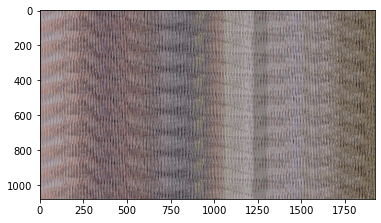

In [84]:
img_norm=undistortImag(Im,K,dist,Cam)
plt.imshow(img_norm)

### Homographies

- **Exercise 2.5**. Consider the following points on a plane:

$ p_1 = \begin{bmatrix} 1 \\ 1\end{bmatrix}$ , $ p_2 = \begin{bmatrix} 0 \\ 3\end{bmatrix}$, $ p_3 = \begin{bmatrix} 2 \\ 3\end{bmatrix}$, $ p_4 = \begin{bmatrix} 2 \\ 4\end{bmatrix}$

Using the homography H, map the points $p_i$ using the homography.

$$ H = \begin{bmatrix} -2 & 0 & 1 \\ 1 & -2 & 0 \\ 0 & 0 & 3 \end{bmatrix}$$
     

<font color='darkblue'> We convert the $p_is$ to homogeneous coordinates, and compute: $$q_ih= H p_{ih}$$
    

In [ ]:
def homography_mapping(H,p):
    P=np.array([p[0],p[1],1])
    mapped_point3D=H@P
    mapped_point2D=[mapped_point3D[0]/mapped_point3D[2], mapped_point3D[1]/mapped_point3D[2]]
    return mapped_point3D,mapped_point2D

In [ ]:
H=[[-2,0,1],[1,-2,0],[0,0,3]]

p1,q1=homography_mapping(H,[1,1])
print('Mapped q_i 2D point:',q1)
p2,q2=homography_mapping(H,[0,3])
print('Mapped q_i 2D point:',q2)
p3,q3=homography_mapping(H,[2,3])
print('Mapped q_i 2D point:',q3)
p4,q4=homography_mapping(H,[2,4])
print('Mapped q_i 2D point:',q4)


- **Exercise 2.6**. Create a function `hest` that takes two sets of points in 2D, q1 and q2, and returns the estimated homography matrix using the linear algorithm.

    Test your function by using the points from the exercise above. Do you get back the exact same homography?
    
<font color='darkblue'> We should obtain the same homography, but multiplied with a scalar such that $∥H∥_F$ = 1.
    
$$ H = \begin{bmatrix} h_1 & h_2 & h_3 \\ h_4 & h_5 & h_6 \\ h_7 & h_8 & h_9 \end{bmatrix}$$
     

In [10]:
def hest(p,q):
    B=np.zeros((1,9))
    for i in range(len(p)):
        x1=p[i][0]
        y1=p[i][1]
        x2=q[i][0]
        y2=q[i][1]
        B_i=np.array([[0,-x2,x2*y1,0,-y2,y1*y2,0,-1,y1],[x2,0,-x2*x1,y2,0,-y2*x1,1,0,-x1],
                      [-x2*y1,x2*x1,0,-y2*y1,y2*x1,0,-y1,x1,0]])
        
        B=np.vstack([B, B_i])
    
    B=B[1:,:] #12x9
    

    #The solution of Ax=0 is found using SVD, where the singular vector v corresponds to 
    #the smallest singular value.
    #OUTPUT: s=singular values, 
    
    u,s,vh= np.linalg.svd(B,full_matrices=True, compute_uv=True)
    #u: 12x12, s:9(vector with singular values), vh: 9x9

    H=H=vh[8,:]
    H_est=H.reshape((3,3),order='F')
    
    
    H_norm=((H_est/H[8])*H[8]).reshape((3,3),order='F')
    
    return H_est, H_norm


In [ ]:
p=np.array([[1,1],[0,3],[2,3],[2,4]])
q=np.array([[-1/3,-1/3],[1/3,-2],[-1,-4/3],[-1,-2]])
H_esti,H_norm=hest(q,p) 

print('H estimation:')
print(np.round(H_esti,3))
print(" ")
print('H estimation normalized:')
print(np.round(H_norm))



- **Exercise 2.7**. Create a helper function `normalize2`. This function finds the transformation T such that $q_{ih} = T p_{ih}$, has mean [0, 0] and standard deviation [1, 1] for all $q_i$.
Test it out with some 2D points and make sure the mean and standard deviation are as expected.

In [ ]:
def normalize2d(p):
    x=np.array([p[:,0],np.ones(len(p))])
    y=np.array([p[:,1],np.ones(len(p))])

    mu_x= np.mean(p[:,0])
    mu_y= np.mean(p[:,1])
    
    std_x= np.std(p[:,0])
    std_y= np.std(p[:,1])
    
    #Tranformation matrix
    T_x= np.array([[1/std_x, -mu_x/std_x]])
    T_y= np.array([[1/std_y, -mu_y/std_y]])
    
    x_norm=(T_x@x).T
    y_norm=(T_y@y).T

    points_norm=np.column_stack((x_norm,y_norm))
    
    return T_x,T_y, points_norm


In [ ]:
T_x,T_y,points_norm=normalize2d(p)
print(T_x)
print(T_y)

print('The mean of the new x is:',np.mean(points_norm[:,0]),'and the std is',np.std(points_norm[:,0]))
print('The mean of the new y is:',np.mean(points_norm[:,1]),'and the std is',np.std(points_norm[:,1]))

- **Exercise 2.8**. Use `normalize2` inside `hest` to normalize the points before estimating the homography, and apply the T matrices to the estimated H so it works on the non-normalized points.



In [ ]:
def hest_normalize2(p,q):
    
    #We normalize the points before estimating the homography
    T_x,T_y,p_norm=normalize2d(p)
    T_x1,T_y1,q_norm=normalize2d(q)
    
    B=np.zeros((1,9))
    for i in range(len(p)):
        x1=p_norm[i][0]
        y1=p_norm[i][1]
        x2=q_norm[i][0]
        y2=q_norm[i][1]
        B_i=np.array([[0,-x2,x2*y1,0,-y2,y1*y2,0,-1,y1],[x2,0,-x2*x1,y2,0,-y2*x1,1,0,-x1],
                      [-x2*y1,x2*x1,0,-y2*y1,y2*x1,0,-y1,x1,0]])
        
        B=np.vstack([B, B_i])
    
    B=B[1:,:] #12x9
    

    #The solution of Ax=0 is found using SVD, where the singular vector v corresponds to 
    #the smallest singular value.
    #OUTPUT: s=singular values, 
    
    u,s,vh= np.linalg.svd(B,full_matrices=True, compute_uv=True)

    H=vh[8,:]
    H_est=H.reshape((3,3),order='F')
    H_norm=((H_est/H[8])*H[8]).reshape((3,3),order='F')
    
    #Apply the T matrices to the estimated H so it works on the non-normalized points.
    T1= np.array([[T_x[0][0],0,T_x[0][1]],[0,T_y[0][0],T_y[0][1]],[0,0,1]])
    T2= np.array([[T_x1[0][0],0,T_x1[0][1]],[0,T_y1[0][0],T_y1[0][1]],[0,0,1]])
    
    TH=T1@H_est
    

    return H_est,H_norm, TH

In [ ]:
H_esti,H_norm,TH=hest_normalize2(q,p) 
print('Estimated H matrix:')
print(np.round(H_esti,4))
print(" ")
print('Estimated H matrix multiply by T matrices:')
print(np.round(TH))


- **Exercise 2.9**. Generate 100 random 2D points, and a random homography. Map the points using the homography, and use `hest` to estimate the homography from the points.



In [ ]:
P2 = np.array([np.random.randint(0,20,100), np.random.randint(0,20,100)])
H_ran=np.random.randint(-5,5,[3,3])
print('Random Homography H:')
print(H_ran)

Q=np.zeros((1,2))
for i in P2.T:
    #Map the points using the homography
    p,q=homography_mapping(H_ran,i)
    Q=np.vstack([Q, q])

Q=Q[1:]


In [ ]:
H_esti,H_norm=hest(Q,P2.T) 

print('H estimation:')
print(H_esti)
print(" ")
print('H estimation normalized:')
print(np.round(H_norm))


- **Exercise 2.10**. Take a piece of paper and draw at least four ×-marks on it in random locations. Make sure to number them.

Put a small object on top of the paper, and use your phone to take pictures of your paper from two different viewpoints (A and B) Get the x, y coordinates of your ×-marks in image coordinates. You can do this by clicking on the points, as shown in https://stackoverflow.com/a/28330835.
Use your annotated points to estimate the homography from image A to image B. Can you click on any point in one image and show where it is in the other image? What happens when you click on the object?




(4032, 3024, 3)


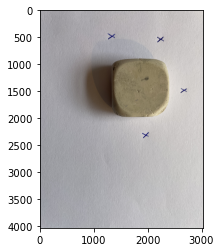

In [3]:
image1 = cv2.imread("IMG_5794.JPG")
print(image1.shape)
Cimg1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
plt.imshow(Cimg1)
plt.show()

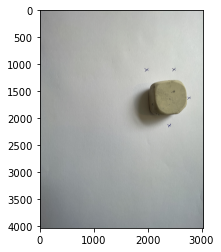

In [4]:
image2 = cv2.imread("IMG_5795.JPG")

Cimg2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
plt.imshow(Cimg2)
plt.show()

In [6]:
#This will display all the available mouse click events  
events = [i for i in dir(cv2) if 'EVENT' in i]
print(events)

#This variable we use to store the pixel location
refPt = []

#click event function
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x,",",y)
        refPt.append([x,y])
        font = cv2.FONT_HERSHEY_SIMPLEX
        strXY = str(x)+", "+str(y)
        cv2.putText(image2, strXY, (x,y), font, 1.5, (0,0,0), 2)
        cv2.imshow("image", image2)

    if event == cv2.EVENT_RBUTTONDOWN:
        blue = image2[y, x, 0]
        green = image2[y, x, 1]
        red = image2[y, x, 2]
        font = cv2.FONT_HERSHEY_SIMPLEX
        strBGR = str(blue)+", "+str(green)+","+str(red)
        cv2.putText(image2, strBGR, (x,y), font, 0.5, (0,255,255), 2)
        cv2.imshow("image", image2)



cv2.imshow("image", image2)

#calling the mouse click event
cv2.setMouseCallback("image", click_event)

cv2.waitKey(0)
cv2.destroyAllWindows()

['EVENT_FLAG_ALTKEY', 'EVENT_FLAG_CTRLKEY', 'EVENT_FLAG_LBUTTON', 'EVENT_FLAG_MBUTTON', 'EVENT_FLAG_RBUTTON', 'EVENT_FLAG_SHIFTKEY', 'EVENT_LBUTTONDBLCLK', 'EVENT_LBUTTONDOWN', 'EVENT_LBUTTONUP', 'EVENT_MBUTTONDBLCLK', 'EVENT_MBUTTONDOWN', 'EVENT_MBUTTONUP', 'EVENT_MOUSEHWHEEL', 'EVENT_MOUSEMOVE', 'EVENT_MOUSEWHEEL', 'EVENT_RBUTTONDBLCLK', 'EVENT_RBUTTONDOWN', 'EVENT_RBUTTONUP']
1967 , 1124
2477 , 1105
2754 , 1634
2382 , 2143


In [22]:
q1=np.array([[1335 , 497],[2225 , 550],[2654 , 1490],[1953 , 2321]])
q2=np.array([[1967 , 1124],[2477 , 1105],[2754 , 1634],[2382 , 2143]])

H_esti,H_norm=hest(q1,q2) 
print('H estimation:')
print(np.round(H_esti,3))


H estimation:
[[-0.001  0.     0.755]
 [-0.    -0.001  0.656]
 [-0.     0.    -0.   ]]
[[-0.001  0.     0.755]
 [-0.    -0.001  0.656]
 [-0.     0.    -0.   ]]


- **Exercise 2.11**. Re-create image A, using only pixel intensities from image B. This can be done in a similar fashion as the undistortion exercise.
Generate an overlay of the two images. Does the object on top align?

